LETS SEE HOW THE DATA IS ORGANIZED 

In [5]:
with open('data/words.txt', 'r') as file:
    for i in range(17):
        line = file.readline()
        print(line, end='')

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word


IMPORT LIBRARIES

In [6]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

PROCESS LINES FROM WORDS.TXT FILE

In [7]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [8]:
print(words_list[:5])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n']


SPLIT THE WORDS_LIST 

In [9]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


GETTING THE CORRESPONDING IMAGE PATH FOR THE WORD LIST

base_path => data folder
base_image_path  => data/words

In [10]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        
        line_split = file_line.strip()
        # if i==0 :
        #    print(line_split)
        line_split = line_split.split(" ")
        # if i==0 :
        #    print(line_split)

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]

        # if i==0 :
        #   print(image_name)

        partI = image_name.split("-")[0]

        # if i==0 : 
        #     print(partI)
           
        partII = image_name.split("-")[1]

        # if i==0 : 
        #   print(partII)
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        # if i==0 : 
        #   print(img_path)
        if os.path.getsize(img_path):
            paths.append(img_path)
            # if i==0 :
            #   print(file_line.split("\n")[0])
            corrected_samples.append(file_line.split("\n")[0])
    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
print()
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
print()
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)
print()

GET LABEL TO IMAGE WHICH IS THE LAST WORD OF THE ORIGINAL LABELS

In [12]:
# Finding maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)
    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Checking some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [13]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels
validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

MAP CHARACTERS TO NUMBERS AND NUMBERS TO CHARACTERS

In [14]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [15]:
print("char_to_num vocabulary:", char_to_num.get_vocabulary())
print("num_to_char vocabulary:", num_to_char.get_vocabulary())

char_to_num vocabulary: ['[UNK]', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
num_to_char vocabulary: ['[UNK]', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


<!-- Resizing images without distortion -->
We have to work with rectangular images. 
While aspect-unaware resizing square images does not introduce a significant amount of distortion this is not the case for rectangular images.
But resizing images to a uniform size is a requirement for mini-batching.
So we need to perform our resizing such that the following criteria are met.
Aspect ratio is preserved.
Content of the images is not affected.

COMPUTER VISION TASK

In [26]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


preprocess image - read , resize , cast as tensor 
vectorize label 
preprocess image and label together for supervised learning
tensorflow casted dataset

In [27]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


Calling the utility funcitons on our image_paths and cleaned labels to create a proper dataset

In [28]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

VISUALIZE THE PREPARED DATASET

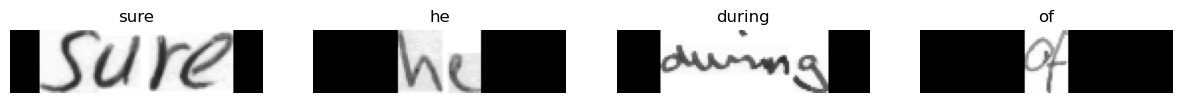

In [35]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(1, 4, figsize=(15, 8))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(label)
        ax[i].axis("off")
plt.show()

MODEL 

In [36]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

GET THE LABELS AND IMAGES SEPERATELY FOR THE VALIDATION DATASET FOR CONVENIENCE

In [38]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

EVALUATION

Edit Distance is the most widely used metric for evaluating OCR models. In this section, we will implement it and use it as a callback to monitor our model.

In [40]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


TRAINING

In [ ]:
epochs = 10  

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


INFERENCE

In [52]:
from keras.models import load_model
prediction_model = load_model('recognition_10_epoch.h5')

2/2 [==============================] - 4s 66ms/step


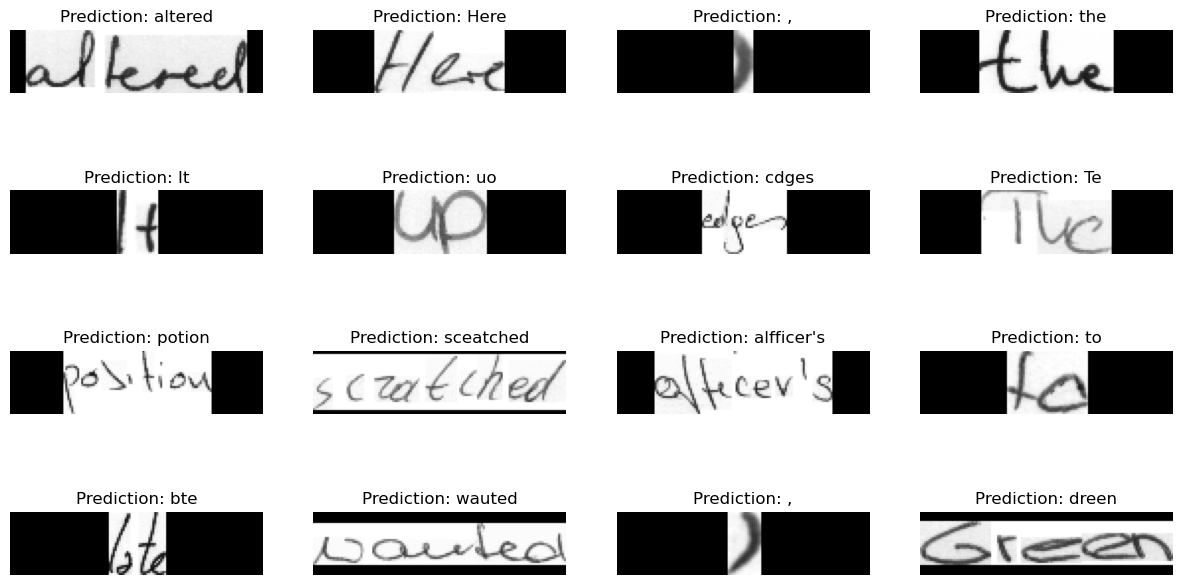

In [53]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()